Original data available at:
https://www.kaggle.com/kaushik3497/imdb-sentiment-analysis

In [1]:
%matplotlib inline
import sys
sys.path.append('../data/')

In [146]:
from typing import Tuple, Sequence, Dict, Callable, Any, List, Pattern, Union, Iterable
import nltk
from concurrent.futures import ProcessPoolExecutor, as_completed
from nltk.tokenize import TreebankWordTokenizer, PunktSentenceTokenizer
from nltk.tag import DefaultTagger, UnigramTagger, BigramTagger
from nltk.corpus import brown
import re
from pathlib import Path
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
import csv
import spacy
import toolz as tz
from pattern.en import parse
import toolz.curried as tzc
import pandas as pd
import matplotlib.pyplot as plt
import pattern
import bs4
from sklearn.model_selection import train_test_split
from functools import partial

In [3]:
# nlp = spacy.load('en')

In [4]:
train_file = Path('../data/labeledTrainData.tsv')
 

In [5]:
f = train_file.open()
records = csv.DictReader(f, delimiter='\t', quoting=csv.QUOTE_NONE)

In [6]:
r = next(records)
r

OrderedDict([('id', '"5814_8"'),
             ('sentiment', '1'),
             ('review',
              '"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it 

In [9]:
# !head ../data/labeledTrainData.tsv

In [10]:
raw_dataset = pd.read_csv(train_file, sep='\t', quoting=csv.QUOTE_NONE) 
# We'll handle quotes manually.

raw_train_dataset, raw_test_dataset = train_test_split(raw_dataset, test_size=0.1)

In [11]:
# raw_train_dataset, raw_devtest_dataset = train_test_split(raw_observable_dataset, test_size=0.1)

In [12]:
def strip_quotes_and_ids(dataset):
    no_id_dataset = dataset.drop('id', 'columns')
    no_id_dataset['review'] = no_id_dataset['review'].str.strip('\""')
    return no_id_dataset



In [13]:
dataset = strip_quotes_and_ids(raw_train_dataset)
dataset.head(10)

,sentiment,review
22094,1,"If you like Deep Purple, you will enjoy in thi..."
22642,0,"OK, my girlfriend and I rented the DVD and abo..."
22439,0,"This movie is written by Charlie Higson, who h..."
3507,0,This movie is just not worth your time. Its re...
7297,0,"\""In 1955, Tobias Schneerbaum disappeared in t..."
15107,1,This movie is a fantastic movie. Everything ab...
1337,1,"i just saw this film, i first saw it when i wa..."
13544,0,"This film, though ostensibly a comedy, is dead..."
21298,0,"Around the late 1970's, animator Don Bluth, fr..."
21634,1,Rudy does it again with this hot off the stree...


In [14]:
dataset.groupby('sentiment').count()

,review
sentiment,
0,11273
1,11227


The dataset is well balanced

count    22500.000000
mean      1324.340089
std       1003.100032
min         52.000000
25%        704.000000
50%        979.000000
75%       1608.000000
max      13708.000000
Name: review, dtype: float64


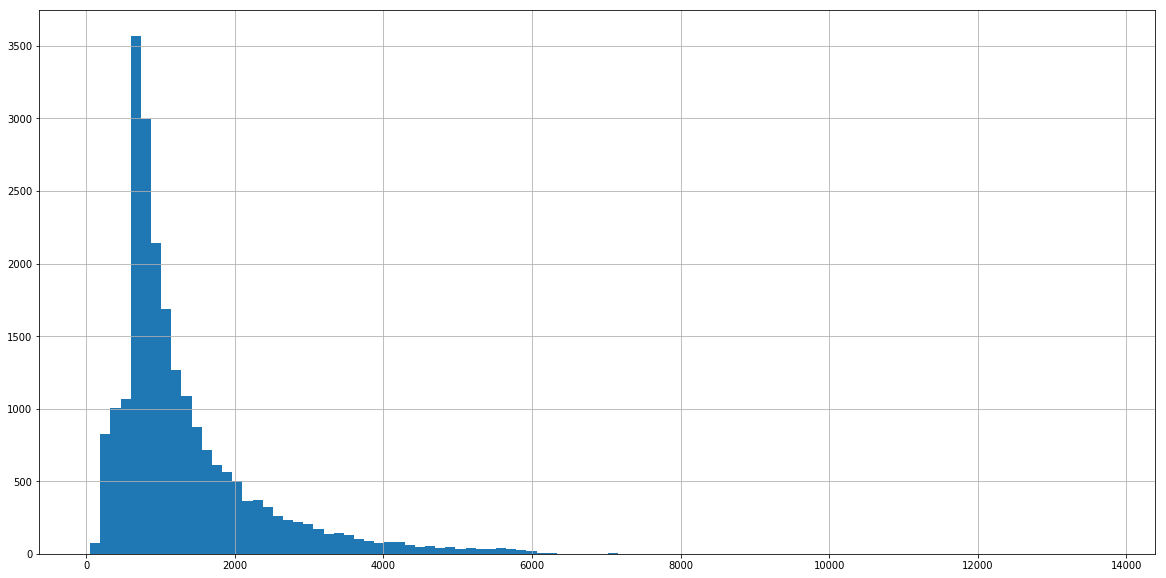

In [15]:
review_lengths = dataset['review'].map(len)
fig = plt.figure(figsize=(20, 10))
review_lengths.hist(bins=100);
print(review_lengths.describe())

In [86]:
sample = dataset.sample(1)
print(f'sentiment: {sample.values[0, 0]}')
review = sample.values[0, 1]
print(review)

sentiment: 0
First, a little summary. This reporter named Torch is basically trying to get out the story of a zombie outbreak and finds the military & government censoring him. Nice message, government censorship and all that, but the way they DID the movie was, well let me explain.<br /><br />This movie is beyond description. The idea that somebody holds it in higher regard than anything by George Romero is justification enough for the reviewer to be committed to a mental institution. The script is atrocious on its own, like it was written by a sixth grader.As for special effects, I understand that independent films have low budgets, and some gore effects looked acceptable, but if you want a scene with fire, here's a tip: buy some nonflammable material, have an extinguisher ready, and get a fire going! Don't digitally add it in and make it look like an explosion from a Nintendo 64 game. The acting, well let's put it this way. In my summer theater program, a cold reading of the script 

In [87]:
# bs4.BeautifulSoup(sample.values[0, 1]).get_text()

Notes:
* need to remove escaped quotes.
* need to remove html tags
* possibly parentheses. [ (][)}{ ]

In [88]:
import requests
def get_raw_english_contractions():
    resp = requests.get('https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions')
    soup = bs4.BeautifulSoup(resp.text)
    table = soup.find('table', attrs={'class': 'wikitable'})
    table.find('tbody')
    data = []
    for row in table.find_all('tr'):
        cols = row.find_all('td')
        data.append([
            c.get_text()\
                .strip()\
                .replace(r'\[.+\]', '')
            for c in cols
        ])
    return data

def get_curated_english_contractions():
    with open('../data/curated_contractions.csv') as f:
        reader = csv.reader(f)
        contractions = [row for row in reader]
    return contractions
        

In [89]:
raw_contractions = get_raw_english_contractions()
with open('../data/raw_contractions.csv', 'wt') as f:
    writer = csv.writer(f)
    writer.writerows(raw_contractions)

In [90]:
# !cp ../data/raw_contractions.csv ../data/curated_contractions.csv

In [91]:
QUOTES_PATTERN = [(r'\\\"|\\\'', '')]
PARENTHESIS_PATTERN = [(r'[]}{)(]', '')]
ENGLISH_CONTRACTIONS = get_curated_english_contractions()

In [92]:


def remove_quotes(text, pattern: Pattern = QUOTES_PATTERN):
    '''
    removes escaped quotes. (\' or \")
    '''
    text = pattern.sub('', text)
    return text

def clean_html(text):
    '''
    removes html tags.
    '''
    soup = bs4.BeautifulSoup(text, 'html.parser')
    return soup.get_text()

class RegexpReplacer:
    def __init__(self, patterns: Sequence[Tuple[Union[str, re.Pattern], str]]):
        self.patterns = [(re.compile(p), r) for p, r in patterns]
    
    def replace(self, text: str) -> str:
        for pattern, repl in self.patterns:
            text = pattern.sub(repl, text)
        return text
    
    def __call__(self, text):
        return self.replace(text)

In [93]:
quote_remover = RegexpReplacer(QUOTES_PATTERN)
parenthesis_remover = RegexpReplacer(PARENTHESIS_PATTERN)
contraction_replacer = RegexpReplacer(ENGLISH_CONTRACTIONS)

In [96]:
unquoted_review = quote_remover(review)
print('\n\nQuoteRemover\n')
print(unquoted_review)

no_parens_review = parenthesis_remover(unquoted_review)
print('\n\nParenthesisRemover\n')
print(no_parens_review)

decontracted_review = contraction_replacer(no_parens_review)
print('\n\nContractionReplacer\n')
print(decontracted_review)

cleaned_html = clean_html(decontracted_review)
print('\n\nCleanHtml\n')
print(cleaned_html)



QuoteRemover

First, a little summary. This reporter named Torch is basically trying to get out the story of a zombie outbreak and finds the military & government censoring him. Nice message, government censorship and all that, but the way they DID the movie was, well let me explain.<br /><br />This movie is beyond description. The idea that somebody holds it in higher regard than anything by George Romero is justification enough for the reviewer to be committed to a mental institution. The script is atrocious on its own, like it was written by a sixth grader.As for special effects, I understand that independent films have low budgets, and some gore effects looked acceptable, but if you want a scene with fire, here's a tip: buy some nonflammable material, have an extinguisher ready, and get a fire going! Don't digitally add it in and make it look like an explosion from a Nintendo 64 game. The acting, well let's put it this way. In my summer theater program, a cold reading of the scri

In [103]:
sent_tokenizer = PunktSentenceTokenizer()
word_tokenizer = TreebankWordTokenizer()
tokenize_text = tzc.compose(tzc.mapcat(word_tokenizer.tokenize), sent_tokenizer.tokenize)

In [107]:
list(tokenize_text(cleaned_html))[:20]

['First',
 ',',
 'a',
 'little',
 'summary',
 '.',
 'This',
 'reporter',
 'named',
 'Torch',
 'is',
 'basically',
 'trying',
 'to',
 'get',
 'out',
 'the',
 'story',
 'of',
 'a']

In [273]:

def process_text(text, func):
    '''
    clean and tokenize a text.
    tokenize: bool indicate if the function should tokenize.
    resolve: bool indicates if the iterator should be outputted to a list or not.
    '''
    return func(text)
    
def create_corpus_processor(*steps):
    '''
    Produces a function that can be applied to a corpus of document, applying each step in series to each document.
    '''
                   
    def process_corpus(corpus: Iterable[str], 
                       map: Callable[[Callable, Iterable], Iterable] = tz.map,
                       collect=None) -> Iterable[str]:
        '''
        Process a corpus, represented as an iterable of text into a clean and tokenized corpus.
        Downstream tasks can be mapped to the return iterable.
        You can provide a custom map, for example to process the items in parallel.
        '''
        
        func = tz.compose(collect, *reversed(steps)) # compose applies last step first.
        apply_steps = partial(process_text, func=func)
        processed_corpus = tz.map(apply_steps, corpus)
        return processed_corpus
    
    return process_corpus



In [274]:
process_corpus = create_corpus_processor(quote_remover, 
                        parenthesis_remover, 
                        contraction_replacer, 
                        clean_html,
                        tokenize_text)
                        
                    
                    

In [275]:
# %%time
with ProcessPoolExecutor() as executor:
    processed_corpus = list(process_corpus(dataset['review'][:10], executor.map, list))

In [276]:
# # %%time
# with ProcessPoolExecutor() as executor:
#     processed_corpus_list = list(executor.map(list, processed_corpus))

In [277]:
processed_corpus[0]

['If',
 'you',
 'like',
 'Deep',
 'Purple',
 ',',
 'you',
 'will',
 'enjoy',
 'in',
 'this',
 'excellent',
 'movie',
 'with',
 'Stephen',
 'Rea',
 'in',
 'main',
 'role',
 '.',
 'The',
 'story',
 'is',
 'about',
 'the',
 'most',
 'famous',
 'rock',
 'group',
 'back',
 'there',
 'in',
 '70s',
 ',',
 'Strange',
 'Fruits',
 ',',
 'and',
 'they',
 'decided',
 'to',
 'play',
 'together',
 'again',
 '.',
 'But',
 ',',
 'of',
 'course',
 ',',
 'there',
 'is',
 'going',
 'to',
 'be',
 'lots',
 'of',
 'problem',
 'during',
 'theirs',
 'concerts',
 '.',
 'Jimmy',
 'Nail',
 'and',
 'Bill',
 'Nighy',
 'are',
 'great',
 ',',
 'and',
 'song',
 'The',
 'Flame',
 'Still',
 'Burns',
 'is',
 'perfect',
 '.',
 'You',
 'have',
 'to',
 'watch',
 'it',
 '.']

In [253]:
list(processed_corpus[3])

['This',
 'movie',
 'is',
 'just',
 'not',
 'worth',
 'your',
 'time',
 '.',
 'Its',
 'reliance',
 'upon',
 'New-Age',
 'mysticism',
 'serves',
 'as',
 'its',
 'only',
 'semi-interesting',
 'distraction',
 '.',
 'The',
 'plot',
 'is',
 'one',
 'that',
 'has',
 'been',
 're-cycled',
 'countless',
 'times.I',
 'was',
 'only',
 'prompted',
 'to',
 'even',
 'spend',
 'the',
 'time',
 'to',
 'put',
 'in',
 'a',
 'comment',
 'when',
 'I',
 'noted',
 'that',
 'some',
 'have',
 'tried',
 'to',
 'prop-up',
 'the',
 'reputation',
 'of',
 'this',
 'drivel',
 '.',
 'Their',
 'motivation',
 '&',
 'objectivity',
 'is',
 'dubious',
 ',',
 'since',
 'they',
 'encourage',
 'you',
 'not',
 'to',
 'look',
 'at',
 'the',
 'movies',
 'faults',
 ',',
 'but',
 'at',
 'its',
 'well',
 'intentioned',
 'message',
 'of',
 'New',
 'Age',
 'consciousness.So',
 'would',
 'it',
 'be',
 'alright',
 'for',
 'some',
 'twenty',
 'to',
 'thirty',
 'Evangelical',
 'Christians',
 ',',
 'or',
 'Islamic',
 'Fundamentalists',

# Preprocessing

Possible steps:
* lowercasing
* stemming
* lemmatization
* stopword removal
* noise removal (ex. html tags)
* tokenization
* enrichment: 
    - POS tagging
    - Chunking
    - Word embedding
    - Phrasing

Notes:
* Test if lowercasing improves performance